In [317]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import io
from datetime import datetime
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
#from dtaidistance import dtw
from sklearn.model_selection import train_test_split 
import timeit
from lightgbm import LGBMRegressor
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving data2021-full.csv to data2021-full.csv


In [422]:
rentalDimensionalData =  pd.read_csv(io.BytesIO(uploaded['data2021-full.csv']))
rentalDimensionalData.head()

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,UNIT_NUM,CITY,ZIPCODE,BLDG_SEQ,NUM_BLDGS,LUC,LU,LU_DESC,BLDG_TYPE,OWN_OCC,OWNER,MAIL_ADDRESSEE,MAIL_ADDRESS,MAIL_CITY,MAIL_STATE,MAIL_ZIPCODE,RES_FLOOR,CD_FLOOR,RES_UNITS,COM_UNITS,LAND_SF,GROSS_AREA,LIVING_AREA,LAND_VALUE,BLDG_VALUE,TOTAL_VALUE,GROSS_TAX,YR_BUILT,YR_REMODEL,STRUCTURE_CLASS,ROOF_STRUCTURE,ROOF_COVER,INT_WALL,EXT_FINISHED,INT_COND,EXT_COND,OVERALL_COND,BED_RMS,FULL_BTH,HLF_BTH,KITCHEN,TT_RMS,BDRM_COND,BTHRM_STYLE1,BTHRM_STYLE2,BTHRM_STYLE3,KITCHEN_TYPE,KITCHEN_STYLE1,KITCHEN_STYLE2,KITCHEN_STYLE3,HEAT_TYPE,HEAT_FUEL,AC_TYPE,FIRE_PLACE,PlUMBING,NUM_PARKING,PROP_VIEW,CORNER_UNIT
0,100001000,NaN,100001000.0,104 A 104,PUTNAM ST,NaN,EAST BOSTON,2128,1.0,1.0,105,R3,THREE-FAM DWELLING,RE - Row End,Y,PASCUCCI CARLO,NaN,195 LEXINGTON ST,EAST BOSTON,MA,02128,3.0,NaN,NaN,NaN,1150.0,3353.0,2202.0,"$179,500.00","$539,900.00","$719,400.00","$7,676.00",1900.0,NaN,R -,F - Flat,C - Composition,N - Normal,A - Asbestos,A - Average,F - Fair,A - Average,6.0,3.0,NaN,3.0,12.0,NaN,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,3F - 3 Full Eat In Kitchens,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,W - Ht Water/Steam,NaN,N - None,NaN,NaN,3.0,A - Average,NaN
1,100002000,NaN,100002000.0,197,LEXINGTON ST,NaN,EAST BOSTON,2128,1.0,1.0,105,R3,THREE-FAM DWELLING,RM - Row Middle,Y,SEMBRANO RODERICK,NaN,197 LEXINGTON ST,EAST BOSTON,MA,02128,3.0,NaN,NaN,NaN,1150.0,3299.0,2307.0,"$180,300.00","$564,500.00","$744,800.00","$7,947.02",1920.0,2000.0,R -,F - Flat,C - Composition,N - Normal,M - Vinyl,A - Average,A - Average,A - Average,3.0,3.0,NaN,3.0,9.0,NaN,M - Modern,M - Modern,M - Modern,3F - 3 Full Eat In Kitchens,M - Modern,M - Modern,M - Modern,F - Forced Hot Air,NaN,C - Central AC,NaN,NaN,NaN,A - Average,NaN
2,100003000,NaN,100003000.0,199,LEXINGTON ST,NaN,EAST BOSTON,2128,1.0,1.0,105,R3,THREE-FAM DWELLING,RM - Row Middle,N,CHEVARRIA ANA S,NaN,199 LEXINGTON ST,EAST BOSTON,MA,02128,3.0,NaN,NaN,NaN,1150.0,3392.0,2268.0,"$180,800.00","$549,700.00","$730,500.00","$7,794.44",1905.0,1985.0,R -,F - Flat,C - Composition,N - Normal,M - Vinyl,A - Average,G - Good,A - Average,5.0,3.0,NaN,3.0,13.0,NaN,M - Modern,M - Modern,M - Modern,3F - 3 Full Eat In Kitchens,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,S - Space Heat,NaN,N - None,NaN,NaN,NaN,A - Average,NaN
3,100004000,NaN,100004000.0,201,LEXINGTON ST,NaN,EAST BOSTON,2128,1.0,1.0,105,R3,THREE-FAM DWELLING,RM - Row Middle,N,"MADDALENI JAMES E, TS",NaN,PO BOX 557 #,EVERETT,MA,02149,3.0,NaN,NaN,NaN,1150.0,3108.0,2028.0,"$181,400.00","$486,500.00","$667,900.00","$7,126.49",1900.0,1991.0,R -,M - Mansard,C - Composition,N - Normal,M - Vinyl,A - Average,A - Average,A - Average,5.0,3.0,NaN,3.0,11.0,NaN,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,3F - 3 Full Eat In Kitchens,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,W - Ht Water/Steam,NaN,N - None,NaN,NaN,NaN,A - Average,NaN
4,100005000,NaN,100005000.0,203,LEXINGTON ST,NaN,EAST BOSTON,2128,1.0,1.0,104,R2,TWO-FAM DWELLING,RE - Row End,Y,DIGIROLAMO JOHN A,NaN,203 LEXINGTON ST,EAST BOSTON,MA,02128,3.0,NaN,NaN,NaN,2010.0,3700.0,2546.0,"$202,800.00","$511,400.00","$714,200.00","$7,620.52",1900.0,1978.0,R -,M - Mansard,C - Composition,N - Normal,M - Vinyl,A - Average,A - Average,A - Average,6.0,3.0,NaN,2.0,13.0,NaN,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,2F - 2 Full Eat In Kitchens,S - Semi-Modern,S - Semi-Modern,NaN,W - Ht Water/Steam,NaN,N - None,NaN,NaN,NaN,A - Average,NaN


In [423]:
cols_df = pd.DataFrame(rentalDimensionalData.dtypes)
num_cols = list(cols_df[cols_df[0]=='int64'].index)
cat_cols = list(cols_df[cols_df[0]=='object'].index)#excluding target column of salary 
print('Numeric variables includes:','\n',num_cols)
print('\n')
print('Categorical variables includes','\n',cat_cols)

Numeric variables includes: 
 ['PID', 'ZIPCODE', 'LUC']


Categorical variables includes 
 ['ST_NUM', 'ST_NAME', 'UNIT_NUM', 'CITY', 'LU', 'LU_DESC', 'BLDG_TYPE', 'OWN_OCC', 'OWNER', 'MAIL_ADDRESSEE', 'MAIL_ADDRESS', 'MAIL_CITY', 'MAIL_STATE', 'MAIL_ZIPCODE', 'LAND_VALUE', 'BLDG_VALUE', 'TOTAL_VALUE', 'GROSS_TAX', 'STRUCTURE_CLASS', 'ROOF_STRUCTURE', 'ROOF_COVER', 'INT_WALL', 'EXT_FINISHED', 'INT_COND', 'EXT_COND', 'OVERALL_COND', 'BDRM_COND', 'BTHRM_STYLE1', 'BTHRM_STYLE2', 'BTHRM_STYLE3', 'KITCHEN_TYPE', 'KITCHEN_STYLE1', 'KITCHEN_STYLE2', 'KITCHEN_STYLE3', 'HEAT_TYPE', 'HEAT_FUEL', 'AC_TYPE', 'PlUMBING', 'PROP_VIEW', 'CORNER_UNIT']


In [424]:
rentalDimensionalData.shape

(177091, 63)

In [421]:
rentalDimensionalData= rentalDimensionalData.loc[rentalDimensionalData['ZIPCODE'].isin(['2115','2125','2215'])]

In [425]:
rentalDimensionalData.shape

(177091, 63)

In [426]:
rentalDimensionalData.head()

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,UNIT_NUM,CITY,ZIPCODE,BLDG_SEQ,NUM_BLDGS,LUC,LU,LU_DESC,BLDG_TYPE,OWN_OCC,OWNER,MAIL_ADDRESSEE,MAIL_ADDRESS,MAIL_CITY,MAIL_STATE,MAIL_ZIPCODE,RES_FLOOR,CD_FLOOR,RES_UNITS,COM_UNITS,LAND_SF,GROSS_AREA,LIVING_AREA,LAND_VALUE,BLDG_VALUE,TOTAL_VALUE,GROSS_TAX,YR_BUILT,YR_REMODEL,STRUCTURE_CLASS,ROOF_STRUCTURE,ROOF_COVER,INT_WALL,EXT_FINISHED,INT_COND,EXT_COND,OVERALL_COND,BED_RMS,FULL_BTH,HLF_BTH,KITCHEN,TT_RMS,BDRM_COND,BTHRM_STYLE1,BTHRM_STYLE2,BTHRM_STYLE3,KITCHEN_TYPE,KITCHEN_STYLE1,KITCHEN_STYLE2,KITCHEN_STYLE3,HEAT_TYPE,HEAT_FUEL,AC_TYPE,FIRE_PLACE,PlUMBING,NUM_PARKING,PROP_VIEW,CORNER_UNIT
0,100001000,NaN,100001000.0,104 A 104,PUTNAM ST,NaN,EAST BOSTON,2128,1.0,1.0,105,R3,THREE-FAM DWELLING,RE - Row End,Y,PASCUCCI CARLO,NaN,195 LEXINGTON ST,EAST BOSTON,MA,02128,3.0,NaN,NaN,NaN,1150.0,3353.0,2202.0,"$179,500.00","$539,900.00","$719,400.00","$7,676.00",1900.0,NaN,R -,F - Flat,C - Composition,N - Normal,A - Asbestos,A - Average,F - Fair,A - Average,6.0,3.0,NaN,3.0,12.0,NaN,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,3F - 3 Full Eat In Kitchens,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,W - Ht Water/Steam,NaN,N - None,NaN,NaN,3.0,A - Average,NaN
1,100002000,NaN,100002000.0,197,LEXINGTON ST,NaN,EAST BOSTON,2128,1.0,1.0,105,R3,THREE-FAM DWELLING,RM - Row Middle,Y,SEMBRANO RODERICK,NaN,197 LEXINGTON ST,EAST BOSTON,MA,02128,3.0,NaN,NaN,NaN,1150.0,3299.0,2307.0,"$180,300.00","$564,500.00","$744,800.00","$7,947.02",1920.0,2000.0,R -,F - Flat,C - Composition,N - Normal,M - Vinyl,A - Average,A - Average,A - Average,3.0,3.0,NaN,3.0,9.0,NaN,M - Modern,M - Modern,M - Modern,3F - 3 Full Eat In Kitchens,M - Modern,M - Modern,M - Modern,F - Forced Hot Air,NaN,C - Central AC,NaN,NaN,NaN,A - Average,NaN
2,100003000,NaN,100003000.0,199,LEXINGTON ST,NaN,EAST BOSTON,2128,1.0,1.0,105,R3,THREE-FAM DWELLING,RM - Row Middle,N,CHEVARRIA ANA S,NaN,199 LEXINGTON ST,EAST BOSTON,MA,02128,3.0,NaN,NaN,NaN,1150.0,3392.0,2268.0,"$180,800.00","$549,700.00","$730,500.00","$7,794.44",1905.0,1985.0,R -,F - Flat,C - Composition,N - Normal,M - Vinyl,A - Average,G - Good,A - Average,5.0,3.0,NaN,3.0,13.0,NaN,M - Modern,M - Modern,M - Modern,3F - 3 Full Eat In Kitchens,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,S - Space Heat,NaN,N - None,NaN,NaN,NaN,A - Average,NaN
3,100004000,NaN,100004000.0,201,LEXINGTON ST,NaN,EAST BOSTON,2128,1.0,1.0,105,R3,THREE-FAM DWELLING,RM - Row Middle,N,"MADDALENI JAMES E, TS",NaN,PO BOX 557 #,EVERETT,MA,02149,3.0,NaN,NaN,NaN,1150.0,3108.0,2028.0,"$181,400.00","$486,500.00","$667,900.00","$7,126.49",1900.0,1991.0,R -,M - Mansard,C - Composition,N - Normal,M - Vinyl,A - Average,A - Average,A - Average,5.0,3.0,NaN,3.0,11.0,NaN,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,3F - 3 Full Eat In Kitchens,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,W - Ht Water/Steam,NaN,N - None,NaN,NaN,NaN,A - Average,NaN
4,100005000,NaN,100005000.0,203,LEXINGTON ST,NaN,EAST BOSTON,2128,1.0,1.0,104,R2,TWO-FAM DWELLING,RE - Row End,Y,DIGIROLAMO JOHN A,NaN,203 LEXINGTON ST,EAST BOSTON,MA,02128,3.0,NaN,NaN,NaN,2010.0,3700.0,2546.0,"$202,800.00","$511,400.00","$714,200.00","$7,620.52",1900.0,1978.0,R -,M - Mansard,C - Composition,N - Normal,M - Vinyl,A - Average,A - Average,A - Average,6.0,3.0,NaN,2.0,13.0,NaN,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,2F - 2 Full Eat In Kitchens,S - Semi-Modern,S - Semi-Modern,NaN,W - Ht Water/Steam,NaN,N - None,NaN,NaN,NaN,A - Average,NaN


In [427]:
rentalDimensionalData.describe()

,PID,CM_ID,GIS_ID,ZIPCODE,BLDG_SEQ,NUM_BLDGS,LUC,RES_FLOOR,CD_FLOOR,RES_UNITS,COM_UNITS,LAND_SF,GROSS_AREA,LIVING_AREA,YR_BUILT,YR_REMODEL,BED_RMS,FULL_BTH,HLF_BTH,KITCHEN,TT_RMS,FIRE_PLACE,NUM_PARKING
count,1.770910e+05,8.725100e+04,1.770880e+05,177091.000000,177035.000000,177035.000000,177091.000000,153619.000000,59801.000000,76469.000000,13480.000000,1.027790e+05,1.539930e+05,1.539830e+05,153794.000000,84939.000000,126479.000000,129628.000000,33696.000000,129631.000000,129379.000000,34721.000000,72930.000000
mean,1.149209e+09,9.205104e+08,1.149222e+09,2129.894263,1.001056,1.016765,202.752263,1.987170,3.930252,1.948214,23.189614,1.238749e+04,4.924071e+03,4.052537e+03,1930.661606,1999.659049,3.250674,1.713596,1.079357,1.356728,7.031079,1.279456,2.357946
std,7.077189e+08,6.891809e+08,7.077202e+08,31.000087,0.034670,0.467695,265.236684,1.524292,5.392752,8.314154,791.761706,3.413119e+05,3.985070e+04,3.718802e+04,42.843223,14.427779,2.064902,0.858136,0.316336,0.671851,4.066075,0.741454,1.764940
min,1.000010e+08,1.000190e+08,1.000010e+08,2026.000000,1.000000,1.000000,13.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000e+00,1.000000e+00,1700.000000,1900.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.018900e+08,4.000260e+08,5.018908e+08,2119.000000,1.000000,1.000000,102.000000,1.000000,2.000000,1.000000,1.000000,2.430000e+03,8.370000e+02,8.280000e+02,1900.000000,1986.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000
50%,1.103190e+09,6.026421e+08,1.103191e+09,2127.000000,1.000000,1.000000,102.000000,2.000000,3.000000,1.000000,4.000000,4.168000e+03,1.879000e+03,1.401000e+03,1918.000000,2003.000000,3.000000,2.000000,1.000000,1.000000,6.000000,1.000000,2.000000
75%,1.810920e+09,1.602535e+09,1.810921e+09,2131.000000,1.000000,1.000000,108.000000,2.500000,4.000000,1.000000,8.000000,6.038000e+03,3.730000e+03,2.518000e+03,1960.000000,2012.000000,4.000000,2.000000,1.000000,1.000000,9.000000,1.000000,3.000000
max,2.205670e+09,2.205665e+09,2.205670e+09,2467.000000,4.000000,119.000000,995.000000,62.000000,60.000000,716.000000,89892.000000,1.015136e+08,6.982322e+06,6.982322e+06,2020.000000,2020.000000,18.000000,17.000000,6.000000,5.000000,78.000000,12.000000,210.000000


In [429]:
rentalDimensionalData = rentalDimensionalData.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [430]:
rentalDimensionalData.describe()

,PID,CM_ID,GIS_ID,ZIPCODE,BLDG_SEQ,NUM_BLDGS,LUC,RES_FLOOR,CD_FLOOR,RES_UNITS,COM_UNITS,LAND_SF,GROSS_AREA,LIVING_AREA,YR_BUILT,YR_REMODEL,BED_RMS,FULL_BTH,HLF_BTH,KITCHEN,TT_RMS,FIRE_PLACE,NUM_PARKING
count,1.770910e+05,1.770910e+05,1.770910e+05,177091.000000,177091.000000,177091.000000,177091.000000,177091.000000,177091.000000,177091.000000,177091.000000,1.770910e+05,1.770910e+05,1.770910e+05,177091.000000,177091.000000,177091.000000,177091.000000,177091.000000,177091.000000,177091.000000,177091.000000,177091.000000
mean,1.149209e+09,6.059477e+08,1.149207e+09,2129.894263,1.001056,1.016760,202.752263,1.856328,2.651817,1.409445,2.689053,9.287506e+03,4.281954e+03,3.523866e+03,1926.627954,1992.030990,2.893236,1.522342,1.015100,1.261126,6.214443,1.054791,1.559232
std,7.077189e+08,5.745525e+08,7.077229e+08,31.000087,0.034665,0.467622,265.236684,1.458613,3.263998,5.483526,218.516300,2.600442e+05,3.719802e+04,3.470380e+04,41.248956,12.388449,1.834259,0.799332,0.141458,0.596135,3.726529,0.346545,1.315101
min,1.000010e+08,1.000190e+08,1.000010e+08,2026.000000,1.000000,1.000000,13.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000e+00,1.000000e+00,1700.000000,1900.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.018900e+08,3.004500e+08,5.018900e+08,2119.000000,1.000000,1.000000,102.000000,1.000000,2.000000,1.000000,1.000000,3.750000e+03,5.980000e+02,5.960000e+02,1900.000000,1985.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000
50%,1.103190e+09,3.004500e+08,1.103190e+09,2127.000000,1.000000,1.000000,102.000000,1.500000,2.000000,1.000000,1.000000,5.000000e+03,1.369000e+03,1.213000e+03,1910.000000,1985.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000
75%,1.810920e+09,6.021010e+08,1.810920e+09,2131.000000,1.000000,1.000000,108.000000,2.000000,2.000000,1.000000,1.000000,5.000000e+03,3.348000e+03,2.290000e+03,1950.000000,2002.000000,3.000000,2.000000,1.000000,1.000000,7.000000,1.000000,2.000000
max,2.205670e+09,2.205665e+09,2.205670e+09,2467.000000,4.000000,119.000000,995.000000,62.000000,60.000000,716.000000,89892.000000,1.015136e+08,6.982322e+06,6.982322e+06,2020.000000,2020.000000,18.000000,17.000000,6.000000,5.000000,78.000000,12.000000,210.000000


In [431]:
rentalDimensionalData['TOTAL_VALUE'] = rentalDimensionalData['TOTAL_VALUE'].str.replace('$', '')
rentalDimensionalData['TOTAL_VALUE'] = rentalDimensionalData['TOTAL_VALUE'].str.replace(',', '')
rentalDimensionalData['TOTAL_VALUE'] = rentalDimensionalData['TOTAL_VALUE'].str.replace(' ', '')

In [432]:
rentalDimensionalData['BLDG_VALUE'] = rentalDimensionalData['BLDG_VALUE'].str.replace('$', '')
rentalDimensionalData['BLDG_VALUE'] = rentalDimensionalData['BLDG_VALUE'].str.replace(',', '')
rentalDimensionalData['BLDG_VALUE'] = rentalDimensionalData['BLDG_VALUE'].str.replace(' ', '')

In [433]:
rentalDimensionalData['LAND_VALUE'] = rentalDimensionalData['LAND_VALUE'].str.replace('$', '')
rentalDimensionalData['LAND_VALUE'] = rentalDimensionalData['LAND_VALUE'].str.replace(',', '')
rentalDimensionalData['LAND_VALUE'] = rentalDimensionalData['LAND_VALUE'].str.replace(' ', '')

In [434]:
rentalDimensionalData.head()

,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,UNIT_NUM,CITY,ZIPCODE,BLDG_SEQ,NUM_BLDGS,LUC,LU,LU_DESC,BLDG_TYPE,OWN_OCC,OWNER,MAIL_ADDRESSEE,MAIL_ADDRESS,MAIL_CITY,MAIL_STATE,MAIL_ZIPCODE,RES_FLOOR,CD_FLOOR,RES_UNITS,COM_UNITS,LAND_SF,GROSS_AREA,LIVING_AREA,LAND_VALUE,BLDG_VALUE,TOTAL_VALUE,GROSS_TAX,YR_BUILT,YR_REMODEL,STRUCTURE_CLASS,ROOF_STRUCTURE,ROOF_COVER,INT_WALL,EXT_FINISHED,INT_COND,EXT_COND,OVERALL_COND,BED_RMS,FULL_BTH,HLF_BTH,KITCHEN,TT_RMS,BDRM_COND,BTHRM_STYLE1,BTHRM_STYLE2,BTHRM_STYLE3,KITCHEN_TYPE,KITCHEN_STYLE1,KITCHEN_STYLE2,KITCHEN_STYLE3,HEAT_TYPE,HEAT_FUEL,AC_TYPE,FIRE_PLACE,PlUMBING,NUM_PARKING,PROP_VIEW,CORNER_UNIT
0,100001000,300450000.0,100001000.0,104 A 104,PUTNAM ST,1,EAST BOSTON,2128,1.0,1.0,105,R3,THREE-FAM DWELLING,RE - Row End,Y,PASCUCCI CARLO,C/O JP MORGAN INVEST MGMT INC,195 LEXINGTON ST,EAST BOSTON,MA,02128,3.0,2.0,1.0,1.0,1150.0,3353.0,2202.0,179500.00,539900.00,719400.00,"$7,676.00",1900.0,1985.0,R -,F - Flat,C - Composition,N - Normal,A - Asbestos,A - Average,F - Fair,A - Average,6.0,3.0,1.0,3.0,12.0,Average,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,3F - 3 Full Eat In Kitchens,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,W - Ht Water/Steam,I - Indiv. Cntrl,N - None,1.0,T - Through,3.0,A - Average,N - No
1,100002000,300450000.0,100002000.0,197,LEXINGTON ST,1,EAST BOSTON,2128,1.0,1.0,105,R3,THREE-FAM DWELLING,RM - Row Middle,Y,SEMBRANO RODERICK,C/O JP MORGAN INVEST MGMT INC,197 LEXINGTON ST,EAST BOSTON,MA,02128,3.0,2.0,1.0,1.0,1150.0,3299.0,2307.0,180300.00,564500.00,744800.00,"$7,947.02",1920.0,2000.0,R -,F - Flat,C - Composition,N - Normal,M - Vinyl,A - Average,A - Average,A - Average,3.0,3.0,1.0,3.0,9.0,Average,M - Modern,M - Modern,M - Modern,3F - 3 Full Eat In Kitchens,M - Modern,M - Modern,M - Modern,F - Forced Hot Air,I - Indiv. Cntrl,C - Central AC,1.0,T - Through,1.0,A - Average,N - No
2,100003000,300450000.0,100003000.0,199,LEXINGTON ST,1,EAST BOSTON,2128,1.0,1.0,105,R3,THREE-FAM DWELLING,RM - Row Middle,N,CHEVARRIA ANA S,C/O JP MORGAN INVEST MGMT INC,199 LEXINGTON ST,EAST BOSTON,MA,02128,3.0,2.0,1.0,1.0,1150.0,3392.0,2268.0,180800.00,549700.00,730500.00,"$7,794.44",1905.0,1985.0,R -,F - Flat,C - Composition,N - Normal,M - Vinyl,A - Average,G - Good,A - Average,5.0,3.0,1.0,3.0,13.0,Average,M - Modern,M - Modern,M - Modern,3F - 3 Full Eat In Kitchens,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,S - Space Heat,I - Indiv. Cntrl,N - None,1.0,T - Through,1.0,A - Average,N - No
3,100004000,300450000.0,100004000.0,201,LEXINGTON ST,1,EAST BOSTON,2128,1.0,1.0,105,R3,THREE-FAM DWELLING,RM - Row Middle,N,"MADDALENI JAMES E, TS",C/O JP MORGAN INVEST MGMT INC,PO BOX 557 #,EVERETT,MA,02149,3.0,2.0,1.0,1.0,1150.0,3108.0,2028.0,181400.00,486500.00,667900.00,"$7,126.49",1900.0,1991.0,R -,M - Mansard,C - Composition,N - Normal,M - Vinyl,A - Average,A - Average,A - Average,5.0,3.0,1.0,3.0,11.0,Average,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,3F - 3 Full Eat In Kitchens,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,W - Ht Water/Steam,I - Indiv. Cntrl,N - None,1.0,T - Through,1.0,A - Average,N - No
4,100005000,300450000.0,100005000.0,203,LEXINGTON ST,1,EAST BOSTON,2128,1.0,1.0,104,R2,TWO-FAM DWELLING,RE - Row End,Y,DIGIROLAMO JOHN A,C/O JP MORGAN INVEST MGMT INC,203 LEXINGTON ST,EAST BOSTON,MA,02128,3.0,2.0,1.0,1.0,2010.0,3700.0,2546.0,202800.00,511400.00,714200.00,"$7,620.52",1900.0,1978.0,R -,M - Mansard,C - Composition,N - Normal,M - Vinyl,A - Average,A - Average,A - Average,6.0,3.0,1.0,2.0,13.0,Average,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,2F - 2 Full Eat In Kitchens,S - Semi-Modern,S - Semi-Modern,S - Semi-Modern,W - Ht Water/Steam,I - Indiv. Cntrl,N - None,1.0,T - Through,1.0,A - Average,N - No


In [435]:
rentalDimensionalData['TOTAL_VALUE'].dtypes

dtype('O')

In [436]:
rentalDimensionalData['BLDG_VALUE'].dtypes

dtype('O')

In [437]:
rentalDimensionalData['TOTAL_VALUE'] = pd.to_numeric(rentalDimensionalData['TOTAL_VALUE'])

In [438]:
rentalDimensionalData['BLDG_VALUE'] = pd.to_numeric(rentalDimensionalData['BLDG_VALUE'])

In [439]:
rentalDimensionalData['LAND_VALUE'] = pd.to_numeric(rentalDimensionalData['LAND_VALUE'])

In [440]:
rentalDimensionalData['TOTAL_VALUE']=rentalDimensionalData['TOTAL_VALUE'].astype(int)

In [441]:
rentalDimensionalData['BLDG_VALUE']=rentalDimensionalData['BLDG_VALUE'].astype(int)

In [442]:
rentalDimensionalData['LAND_VALUE']=rentalDimensionalData['LAND_VALUE'].astype(int)

In [443]:
rentalDimensionalData['TOTAL_VALUE'].dtypes

dtype('int64')

In [444]:
rentalDimensionalData['BLDG_VALUE'].dtypes

dtype('int64')

In [445]:
rentalDimensionalData['TOTAL_VALUE']=rentalDimensionalData['TOTAL_VALUE'].astype(int)

In [446]:
rentalDimensionalData['TOTAL_VALUE'] = rentalDimensionalData['TOTAL_VALUE']/1000 

In [447]:
rentalDimensionalData['BLDG_VALUE'] = rentalDimensionalData['BLDG_VALUE']/1000 

In [448]:
rentalDimensionalData['LAND_VALUE'] = rentalDimensionalData['LAND_VALUE']/1000 

In [449]:
train_pivot = pd.pivot_table(rentalDimensionalData,values='TOTAL_VALUE',index='PID',aggfunc='sum')
train_pivot

,TOTAL_VALUE
PID,
100001000,719.4
100002000,744.8
100003000,730.5
100004000,667.9
100005000,714.2
...,...
2205666000,240.5
2205667000,69.0
2205668000,1227.7


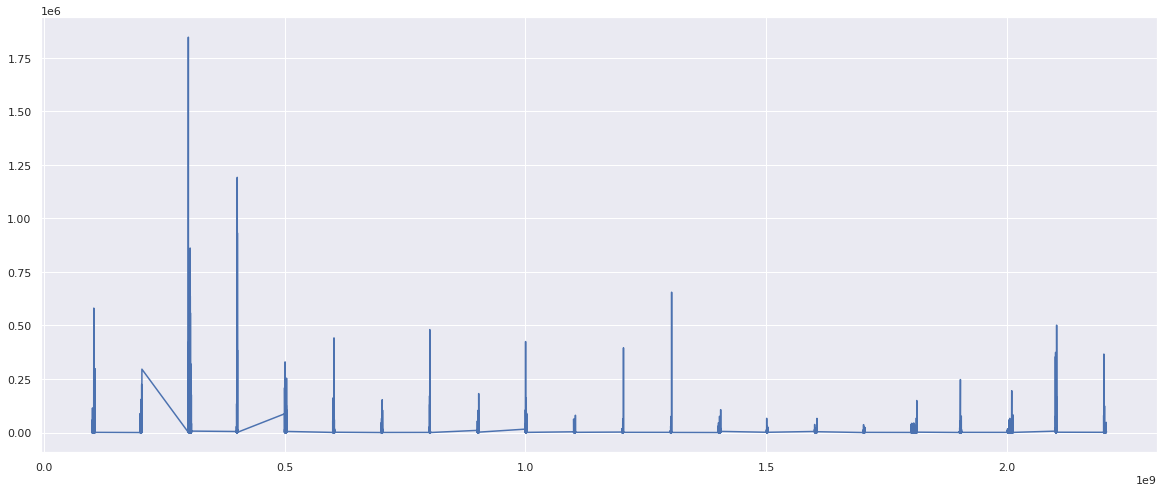

In [450]:
plt.figure(figsize=(20,8))
plt.plot(train_pivot);

In [451]:
rentalDimensionalData = rentalDimensionalData[(rentalDimensionalData['TOTAL_VALUE'] > 10) & (rentalDimensionalData['TOTAL_VALUE'] < 8000)]

In [354]:
rentalDimensionalData = rentalDimensionalData[(rentalDimensionalData['BED_RMS'] < 10)]

In [452]:
rentalDimensionalData.corr()

,PID,CM_ID,GIS_ID,ZIPCODE,BLDG_SEQ,NUM_BLDGS,LUC,RES_FLOOR,CD_FLOOR,RES_UNITS,COM_UNITS,LAND_SF,GROSS_AREA,LIVING_AREA,LAND_VALUE,BLDG_VALUE,TOTAL_VALUE,YR_BUILT,YR_REMODEL,BED_RMS,FULL_BTH,HLF_BTH,KITCHEN,TT_RMS,FIRE_PLACE,NUM_PARKING
PID,1.000000,0.405520,0.999999,0.191394,0.014519,0.008696,-0.061606,-0.014529,-0.194343,-0.013313,0.001797,0.037610,0.079899,0.040112,-0.041861,-0.217600,-0.157629,0.075281,-0.064226,0.224542,0.037280,0.020365,0.092310,0.227157,-0.030816,0.343621
CM_ID,0.405520,1.000000,0.405523,0.209792,-0.016500,-0.000491,0.044749,-0.107912,-0.047008,0.054973,-0.007277,-0.015205,-0.165556,-0.127960,-0.114327,-0.120754,-0.191683,0.202674,0.004177,-0.265873,-0.194430,-0.047905,-0.236475,-0.273429,-0.056351,-0.201745
GIS_ID,0.999999,0.405523,1.000000,0.191387,0.014519,0.008696,-0.061607,-0.014526,-0.194342,-0.013313,0.001797,0.037610,0.079901,0.040114,-0.041861,-0.217607,-0.157635,0.075280,-0.064227,0.224543,0.037283,0.020365,0.092310,0.227160,-0.030816,0.343621
ZIPCODE,0.191394,0.209792,0.191387,1.000000,-0.001185,-0.001651,-0.029328,-0.048811,-0.030425,0.004879,-0.000063,0.018627,-0.012800,-0.010674,-0.003680,-0.022620,-0.023491,0.081344,-0.037921,-0.047095,-0.035007,0.002939,-0.043511,-0.047172,-0.024271,0.020532
BLDG_SEQ,0.014519,-0.016500,0.014519,-0.001185,1.000000,0.173579,-0.010490,0.002903,-0.006289,-0.002351,-0.000446,-0.001598,0.001982,0.000199,-0.006591,-0.027125,-0.025882,0.005697,-0.005898,0.009047,0.018536,0.020848,0.015094,0.012295,-0.001508,0.011322
NUM_BLDGS,0.008696,-0.000491,0.008696,-0.001651,0.173579,1.000000,0.048197,0.032972,-0.009716,0.082813,0.029953,0.114547,0.300471,0.291094,0.068528,0.018884,0.044035,0.029155,-0.004652,-0.009236,-0.013423,0.007047,-0.004967,-0.011881,-0.005515,-0.008097
LUC,-0.061606,0.044749,-0.061607,-0.029328,-0.010490,0.048197,1.000000,0.217919,-0.070844,0.192465,0.004018,0.139720,-0.044334,-0.033661,0.126029,-0.197054,-0.105876,0.034340,0.026481,-0.171121,-0.234594,-0.032629,-0.154054,-0.210138,-0.057284,-0.162963
RES_FLOOR,-0.014529,-0.107912,-0.014526,-0.048811,0.002903,0.032972,0.217919,1.000000,-0.121521,0.320498,0.021733,0.007159,0.233529,0.218842,0.158685,0.098845,0.164474,0.038947,0.134541,0.310895,0.252483,0.066806,0.286247,0.313114,0.067129,0.097422
CD_FLOOR,-0.194343,-0.047008,-0.194342,-0.030425,-0.006289,-0.009716,-0.070844,-0.121521,1.000000,-0.015560,0.001907,-0.010656,-0.048600,-0.030150,-0.043629,0.307422,0.208551,0.250279,-0.043483,-0.130035,0.033231,-0.019738,-0.090556,-0.129935,-0.022496,-0.075953
RES_UNITS,-0.013313,0.054973,-0.013313,0.004879,-0.002351,0.082813,0.192465,0.320498,-0.015560,1.000000,0.000954,0.096285,-0.035843,-0.032581,-0.015223,-0.065134,-0.062680,0.101747,0.007403,-0.037475,-0.050601,-0.007994,-0.033732,-0.045861,-0.012335,-0.035257


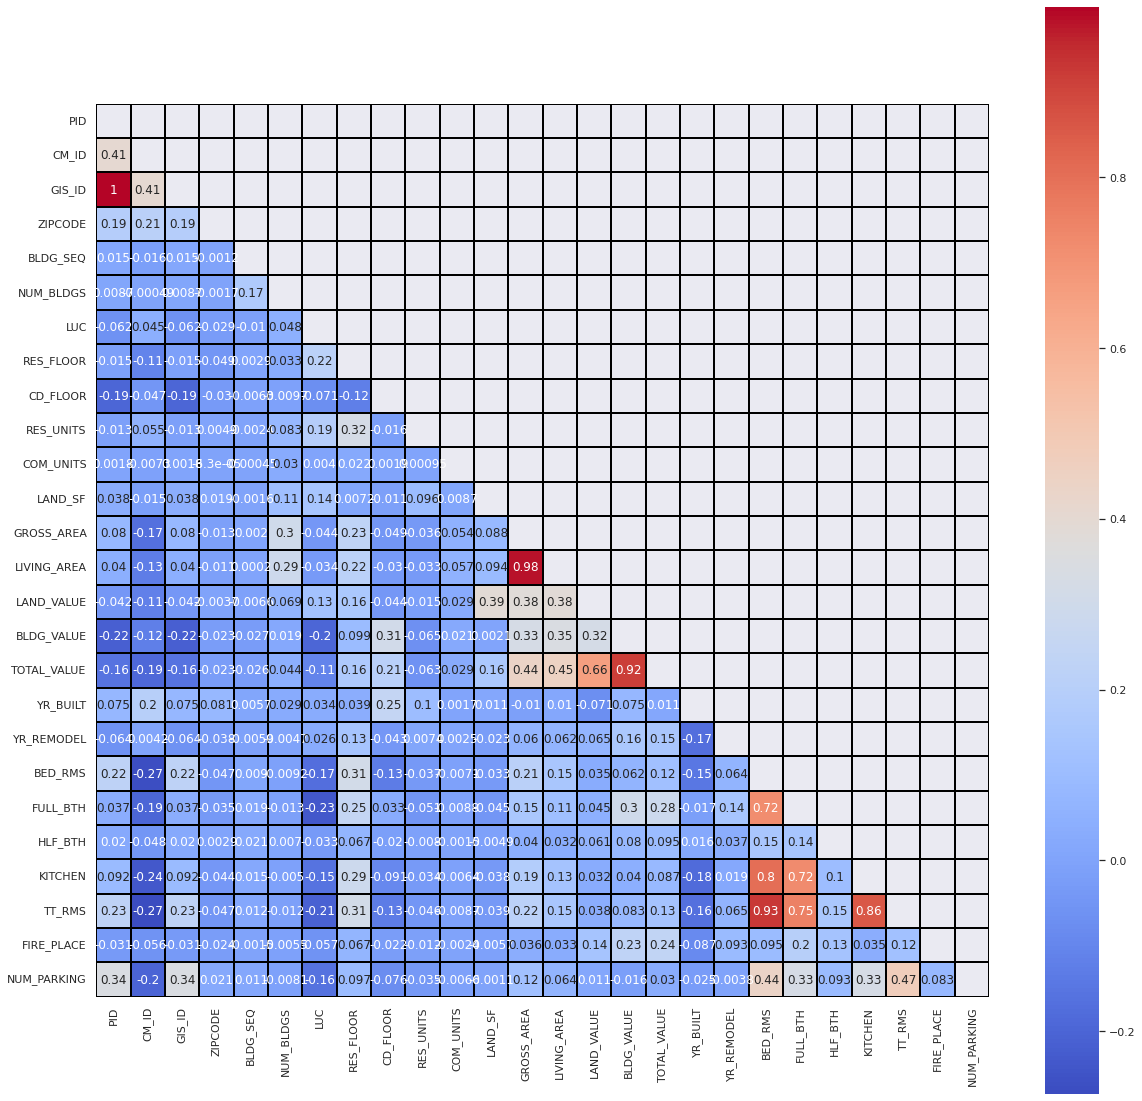

In [453]:
plt.figure(figsize=(20,20))
correlation = rentalDimensionalData.corr()
matrix = np.triu(correlation)
sns.heatmap(correlation,cmap='coolwarm',square=True,linecolor='black',linewidths=1,
            mask=matrix,annot=True)
plt.show()

In [357]:
rentalDimensionalData.describe()

,PID,CM_ID,GIS_ID,ZIPCODE,BLDG_SEQ,NUM_BLDGS,LUC,RES_FLOOR,CD_FLOOR,RES_UNITS,COM_UNITS,LAND_SF,GROSS_AREA,LIVING_AREA,LAND_VALUE,BLDG_VALUE,TOTAL_VALUE,YR_BUILT,YR_REMODEL,BED_RMS,FULL_BTH,HLF_BTH,KITCHEN,TT_RMS,FIRE_PLACE,NUM_PARKING
count,1.588700e+04,1.588700e+04,1.588700e+04,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000,15887.000000
mean,9.241080e+08,6.892133e+08,9.241079e+08,2141.998175,1.000692,1.009316,212.257821,1.856077,2.832945,1.441304,2.025744,4932.724932,2481.746774,1979.634796,417.361659,654.413150,811.797682,1919.429156,1992.280166,2.700888,1.441556,1.008812,1.259143,5.739535,1.050293,1.282180
std,5.033895e+08,4.281454e+08,5.033895e+08,39.427432,0.026305,0.385320,276.276839,1.983148,3.859083,4.799892,10.072538,15013.266464,7210.330002,5908.483250,365.537445,803.116269,1021.834226,38.728338,12.335943,1.900268,0.769046,0.110156,0.627846,3.971241,0.298430,0.904268
min,1.016190e+08,1.016190e+08,1.016190e+08,2115.000000,1.000000,1.000000,13.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.400000,0.009000,10.400000,1800.000000,1915.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.036595e+08,5.038070e+08,5.036595e+08,2115.000000,1.000000,1.000000,102.000000,1.000000,2.000000,1.000000,1.000000,3250.000000,385.000000,385.000000,262.400000,284.700000,337.300000,1900.000000,1986.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000
50%,7.034670e+08,5.038070e+08,7.034670e+08,2125.000000,1.000000,1.000000,102.000000,1.000000,2.000000,1.000000,1.000000,4000.000000,954.000000,949.000000,424.737000,485.500000,545.500000,1905.000000,1986.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000
75%,1.302270e+09,5.042750e+08,1.302270e+09,2125.000000,1.000000,1.000000,108.000000,2.500000,2.000000,1.000000,1.000000,4000.000000,3290.500000,2349.500000,424.737000,736.550000,871.150000,1920.000000,2003.000000,3.000000,2.000000,1.000000,1.000000,6.000000,1.000000,1.000000
max,2.102478e+09,2.102478e+09,2.102478e+09,2215.000000,2.000000,47.000000,995.000000,62.000000,58.000000,240.000000,399.000000,634757.000000,631559.000000,514604.000000,7660.200000,7927.400000,7995.900000,2019.000000,2020.000000,9.000000,8.000000,3.000000,4.000000,24.000000,7.000000,10.000000


## Numerical Datas classification around mean Total value of 1082

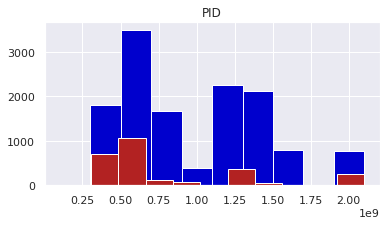

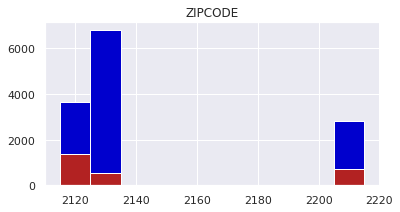

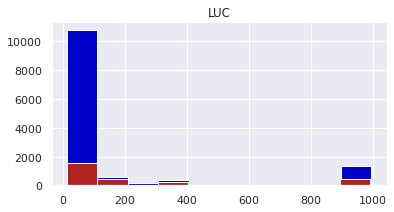

In [358]:
for i in num_cols:
    plt.figure(figsize=(6,3))
    rentalDimensionalData[rentalDimensionalData['TOTAL_VALUE'] <= 1082][i].hist(color='mediumblue')
    rentalDimensionalData[rentalDimensionalData['TOTAL_VALUE'] >= 1082][i].hist(color='firebrick')
    plt.title(i)
    plt.show()

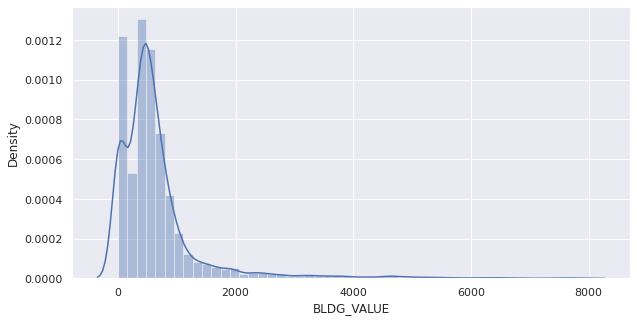

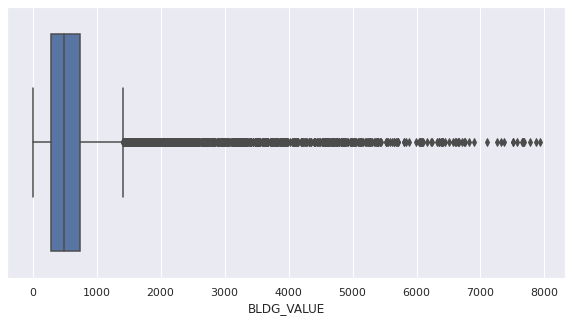

In [359]:
sns.set(rc = {'figure.figsize':(10,5)})
sns.distplot(rentalDimensionalData['BLDG_VALUE'])
plt.show()
sns.boxplot(rentalDimensionalData['BLDG_VALUE'])
plt.show()

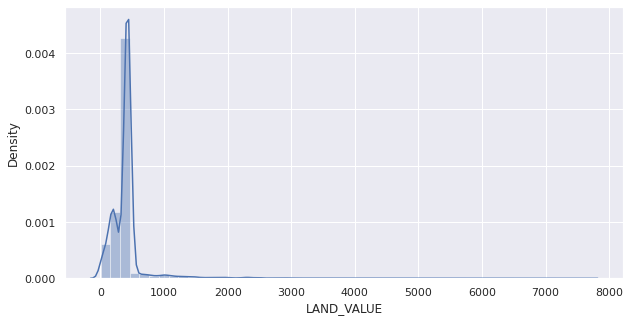

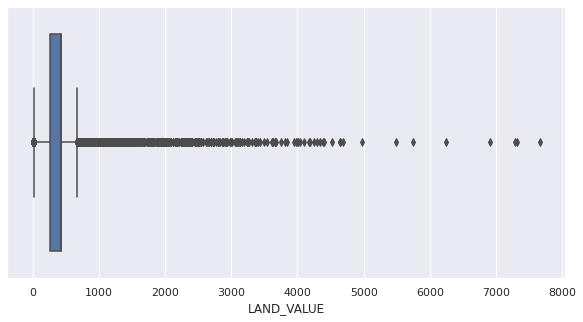

In [360]:
sns.distplot(rentalDimensionalData['LAND_VALUE'])
plt.show()
sns.boxplot(rentalDimensionalData['LAND_VALUE'])
plt.show()

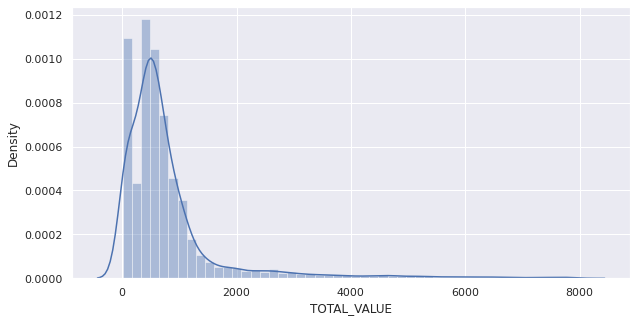

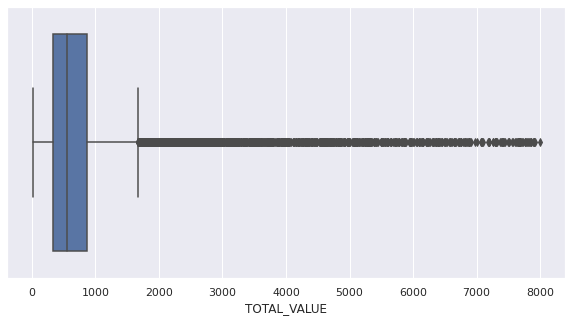

In [361]:
sns.distplot(rentalDimensionalData['TOTAL_VALUE'])
plt.show()
sns.boxplot(rentalDimensionalData['TOTAL_VALUE'])
plt.show()

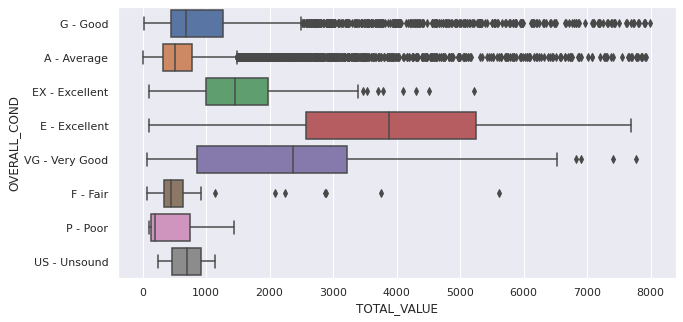

In [362]:
sns.boxplot(x=rentalDimensionalData['TOTAL_VALUE'], y=rentalDimensionalData['OVERALL_COND']);

In [363]:
bins = [0, 1000, 2000, 3000,4000,5000,6000, 7000,10000000]
rentalDimensionalData['LAND_AREA_GRP'] = pd.cut(rentalDimensionalData.LAND_SF, bins)

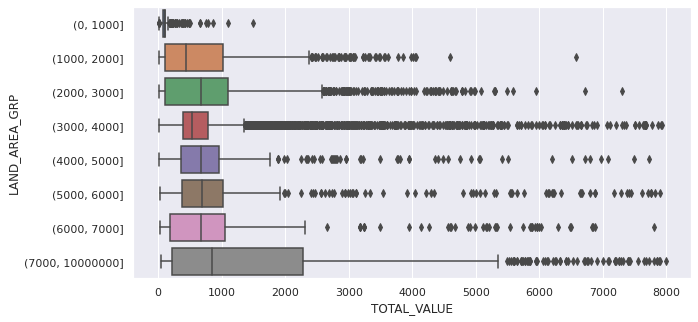

In [364]:
sns.boxplot(x=rentalDimensionalData['TOTAL_VALUE'], y=rentalDimensionalData['LAND_AREA_GRP']);

In [365]:
rentalDimensionalData['ZIPCODE'] = rentalDimensionalData.ZIPCODE.astype(str)

In [366]:
rentalDimensionalData['ZIPCODE'].unique()

array(['2115', '2215', '2125'], dtype=object)

In [367]:
rentalDimensionalData['ZIPCODE']=rentalDimensionalData['ZIPCODE'].map({'2115':'Northeastern', '2125':'University of Massachusetts', '2215':'Boston university'})

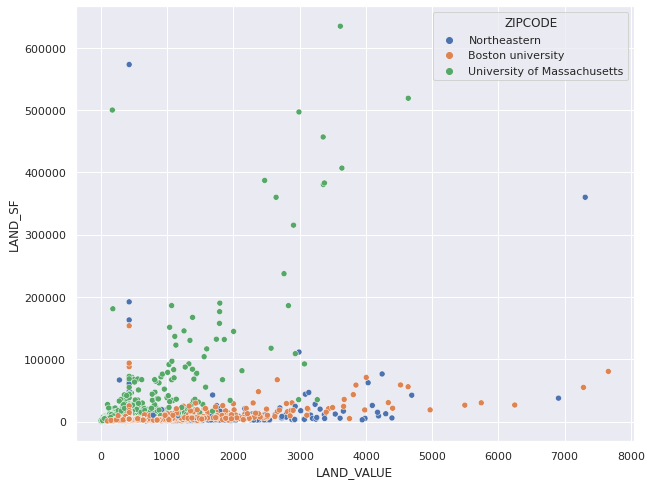

In [368]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.scatterplot(y=rentalDimensionalData['LAND_SF'], x=rentalDimensionalData['LAND_VALUE'],hue=rentalDimensionalData['ZIPCODE'])
plt.show()

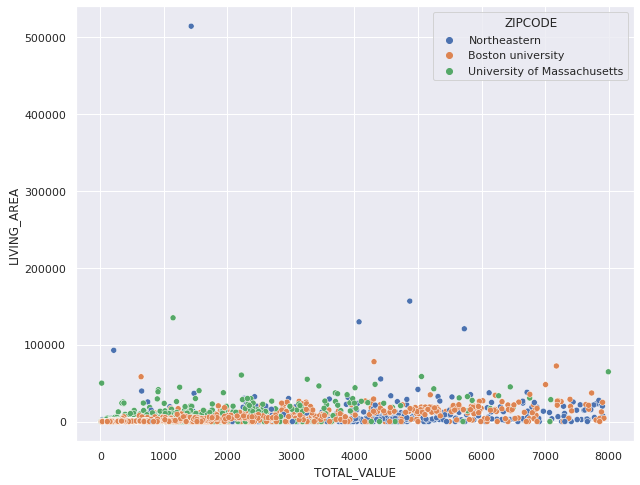

In [369]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.scatterplot(y=rentalDimensionalData['LIVING_AREA'], x=rentalDimensionalData['TOTAL_VALUE'],hue=rentalDimensionalData['ZIPCODE'])
plt.show()

In [370]:
df = rentalDimensionalData.groupby(['INT_COND', 'ZIPCODE']).agg(AVG_PROP_VALUE=("TOTAL_VALUE", 'mean'))
df = df.reset_index()

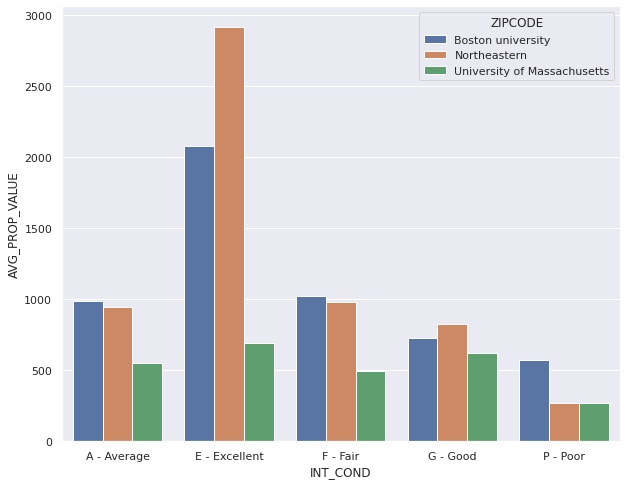

In [371]:
sns.barplot(x=df['INT_COND'], y=df['AVG_PROP_VALUE'], hue=df['ZIPCODE']);

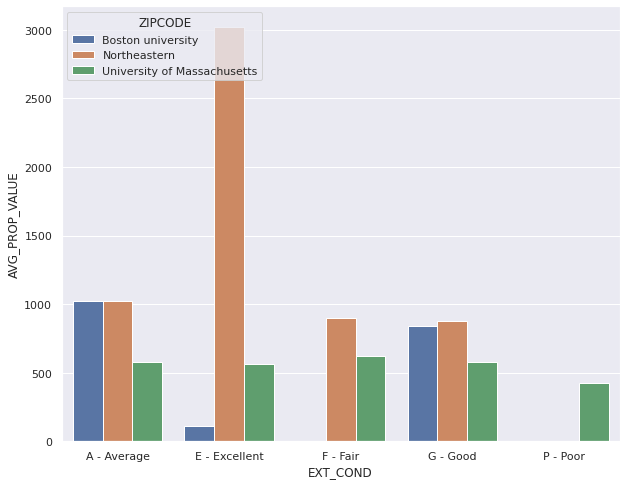

In [372]:
df = rentalDimensionalData.groupby(['EXT_COND', 'ZIPCODE']).agg(AVG_PROP_VALUE=("TOTAL_VALUE", 'mean'))
df = df.reset_index()
sns.barplot(x=df['EXT_COND'], y=df['AVG_PROP_VALUE'], hue=df['ZIPCODE']);

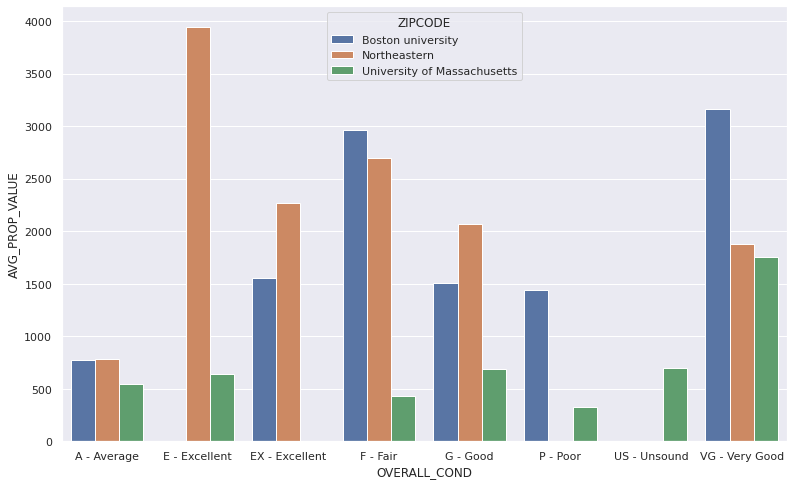

In [373]:
sns.set(rc = {'figure.figsize':(13,8)})
df = rentalDimensionalData.groupby(['OVERALL_COND', 'ZIPCODE']).agg(AVG_PROP_VALUE=("TOTAL_VALUE", 'mean'))
df = df.reset_index()
sns.barplot(x=df['OVERALL_COND'], y=df['AVG_PROP_VALUE'], hue=df['ZIPCODE']);

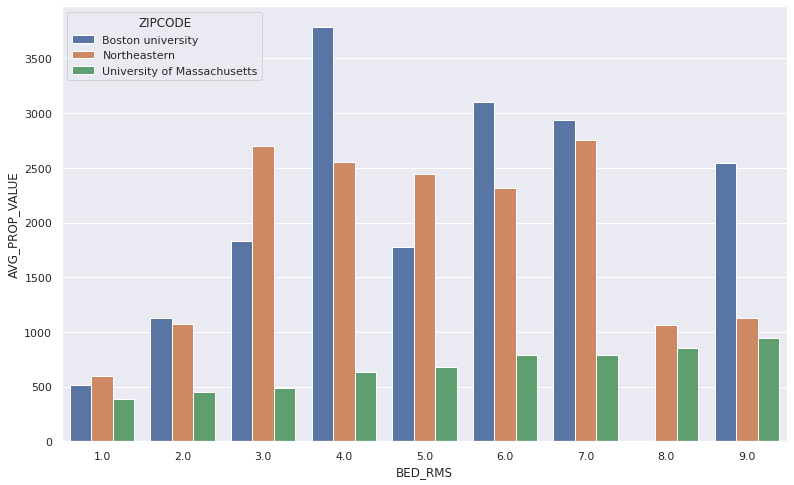

In [374]:
sns.set(rc = {'figure.figsize':(13,8)})
df = rentalDimensionalData.groupby(['BED_RMS', 'ZIPCODE']).agg(AVG_PROP_VALUE=("TOTAL_VALUE", 'mean'))
df = df.reset_index()
sns.barplot(x=df['BED_RMS'], y=df['AVG_PROP_VALUE'], hue=df['ZIPCODE']);

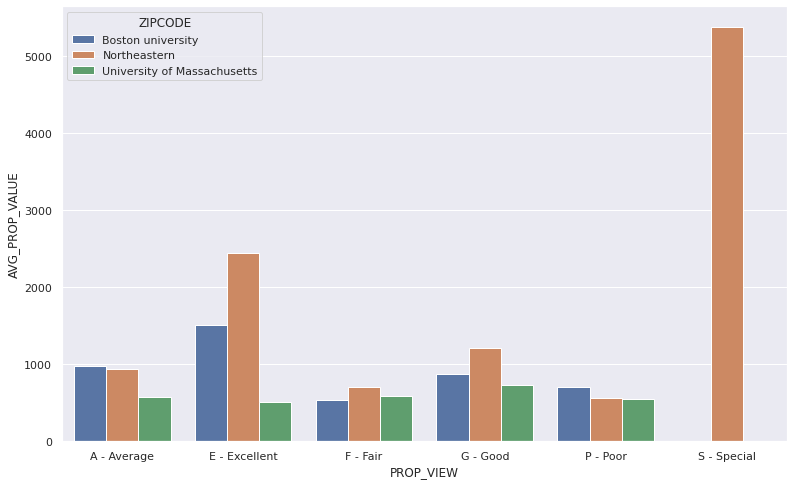

In [375]:
sns.set(rc = {'figure.figsize':(13,8)})
df = rentalDimensionalData.groupby(['PROP_VIEW', 'ZIPCODE']).agg(AVG_PROP_VALUE=("TOTAL_VALUE", 'mean'))
df = df.reset_index()
sns.barplot(x=df['PROP_VIEW'], y=df['AVG_PROP_VALUE'], hue=df['ZIPCODE']);

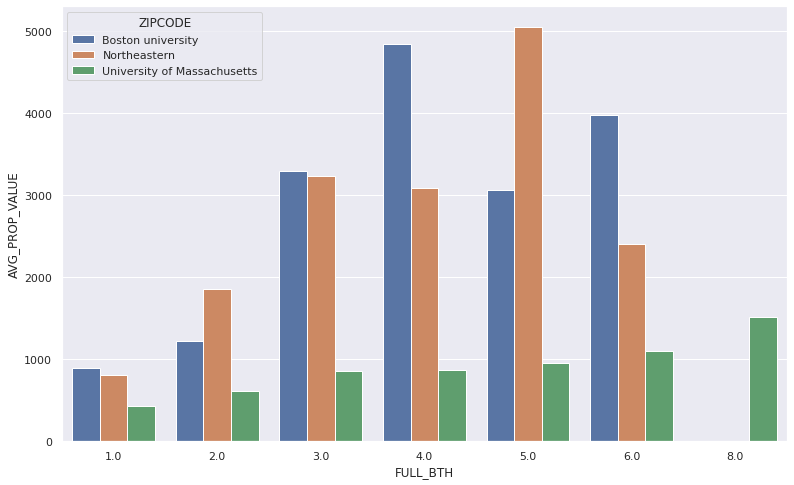

In [376]:
sns.set(rc = {'figure.figsize':(13,8)})
df = rentalDimensionalData.groupby(['FULL_BTH', 'ZIPCODE']).agg(AVG_PROP_VALUE=("TOTAL_VALUE", 'mean'))
df = df.reset_index()
sns.barplot(x=df['FULL_BTH'], y=df['AVG_PROP_VALUE'], hue=df['ZIPCODE']);

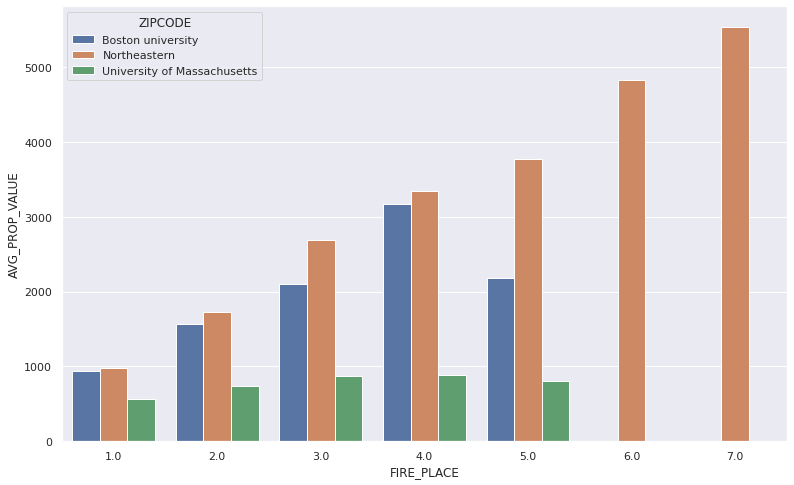

In [377]:
sns.set(rc = {'figure.figsize':(13,8)})
df = rentalDimensionalData.groupby(['FIRE_PLACE', 'ZIPCODE']).agg(AVG_PROP_VALUE=("TOTAL_VALUE", 'mean'))
df = df.reset_index()
sns.barplot(x=df['FIRE_PLACE'], y=df['AVG_PROP_VALUE'], hue=df['ZIPCODE']);

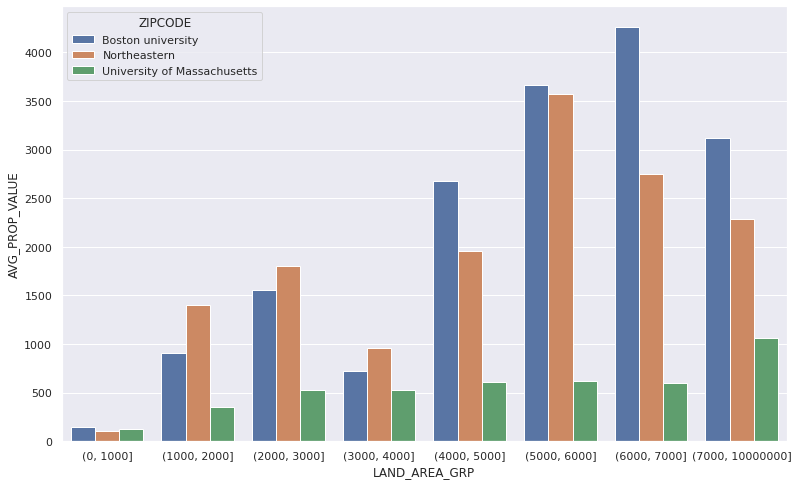

In [378]:
sns.set(rc = {'figure.figsize':(13,8)})
df = rentalDimensionalData.groupby(['LAND_AREA_GRP', 'ZIPCODE']).agg(AVG_PROP_VALUE=("TOTAL_VALUE", 'mean'))
df = df.reset_index()
sns.barplot(x=df['LAND_AREA_GRP'], y=df['AVG_PROP_VALUE'], hue=df['ZIPCODE']);

In [379]:
rentalDimensionalData = rentalDimensionalData[(rentalDimensionalData['YR_REMODEL'] > 2000)]

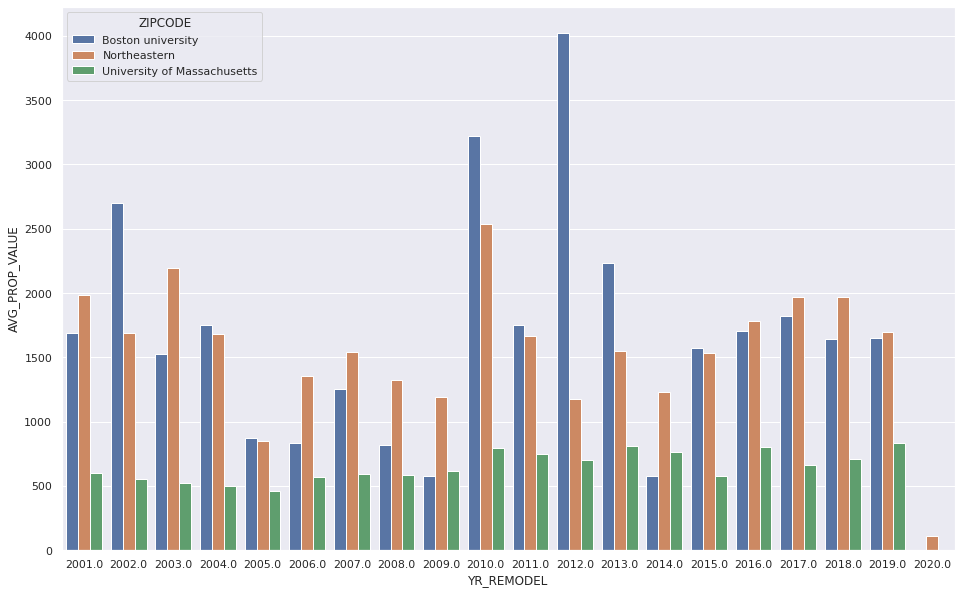

In [380]:
sns.set(rc = {'figure.figsize':(16,10)})
df = rentalDimensionalData.groupby(['YR_REMODEL', 'ZIPCODE']).agg(AVG_PROP_VALUE=("TOTAL_VALUE", 'mean'))
df = df.reset_index()
sns.barplot(x=df['YR_REMODEL'], y=df['AVG_PROP_VALUE'], hue=df['ZIPCODE']);

In [381]:
table = pd.pivot_table(data=rentalDimensionalData,index=['BED_RMS'])
table

,BLDG_SEQ,BLDG_VALUE,CD_FLOOR,CM_ID,COM_UNITS,FIRE_PLACE,FULL_BTH,GIS_ID,GROSS_AREA,HLF_BTH,KITCHEN,LAND_SF,LAND_VALUE,LIVING_AREA,LUC,NUM_BLDGS,NUM_PARKING,PID,RES_FLOOR,RES_UNITS,TOTAL_VALUE,TT_RMS,YR_BUILT,YR_REMODEL
BED_RMS,,,,,,,,,,,,,,,,,,,,,,,,
1.0,1.001808,594.379204,3.066908,7.043879e+08,1.000000,1.045208,1.052441,7.065531e+08,703.752260,1.000000,1.000000,3996.564195,424.263515,700.193490,102.010850,1.001808,1.007233,7.065531e+08,1.054250,1.000000,594.868716,3.177215,1910.141049,2010.160940
2.0,1.000400,826.331283,2.334668,8.731516e+08,3.785829,1.043235,1.191753,9.718500e+08,3797.088871,1.000801,1.003603,5009.743395,565.611161,3240.781825,325.338671,1.008807,1.036429,9.718500e+08,2.613291,2.144115,1101.152644,4.160128,1915.022018,2010.102082
3.0,1.000000,988.419112,2.364892,9.370668e+08,1.000000,1.147929,1.662722,1.067726e+09,1775.368836,1.009862,1.080868,3917.358974,395.981744,1573.731755,103.613412,1.003945,1.317554,1.067726e+09,1.542406,1.003945,1039.259152,6.270217,1909.593688,2009.684418
4.0,1.004673,1070.522897,2.070093,5.905218e+08,1.000000,1.317757,2.299065,1.096818e+09,3463.948598,1.032710,1.500000,3840.808411,358.415308,2533.313084,106.233645,1.004673,2.042056,1.096818e+09,2.214953,1.004673,1334.189720,9.154206,1903.224299,2010.322430
5.0,1.000000,717.661532,1.992908,5.101501e+08,1.000000,1.241135,2.524823,1.136976e+09,3953.716312,1.021277,1.879433,3971.921986,293.960553,2759.411348,103.304965,1.007092,2.425532,1.136976e+09,2.390071,1.000000,999.572809,10.765957,1899.482270,2010.950355
6.0,1.000000,733.511111,2.000000,5.101438e+08,1.000000,1.158730,2.968254,1.168520e+09,4820.607143,1.087302,2.547619,3915.071429,270.425631,3294.047619,114.488095,1.007937,2.234127,1.168520e+09,2.684524,1.000000,992.159127,13.464286,1905.130952,2010.583333
7.0,1.000000,649.903131,2.000000,5.070684e+08,1.000000,1.213115,3.163934,1.197354e+09,4727.393443,1.049180,2.360656,4320.655738,233.696574,3220.901639,104.573770,1.000000,2.606557,1.197354e+09,2.459016,1.000000,876.636803,13.393443,1901.885246,2011.754098
8.0,1.000000,682.891429,2.000000,5.038070e+08,1.000000,1.071429,3.128571,1.266332e+09,5247.814286,1.014286,2.857143,3845.414286,227.704814,3577.657143,116.271429,1.000000,2.142857,1.266332e+09,2.757143,1.000000,905.178571,15.442857,1906.642857,2011.014286
9.0,1.000000,817.671707,2.000000,5.038070e+08,1.000000,1.007143,3.228571,1.204387e+09,5741.650000,1.121429,2.950000,3614.928571,223.677807,3961.500000,127.357143,1.000000,2.014286,1.204387e+09,2.932143,1.014286,1035.326129,17.021429,1905.921429,2011.107143


In [382]:
table.drop(table.columns.difference(['TOTAL_VALUE']), 1, inplace=True)

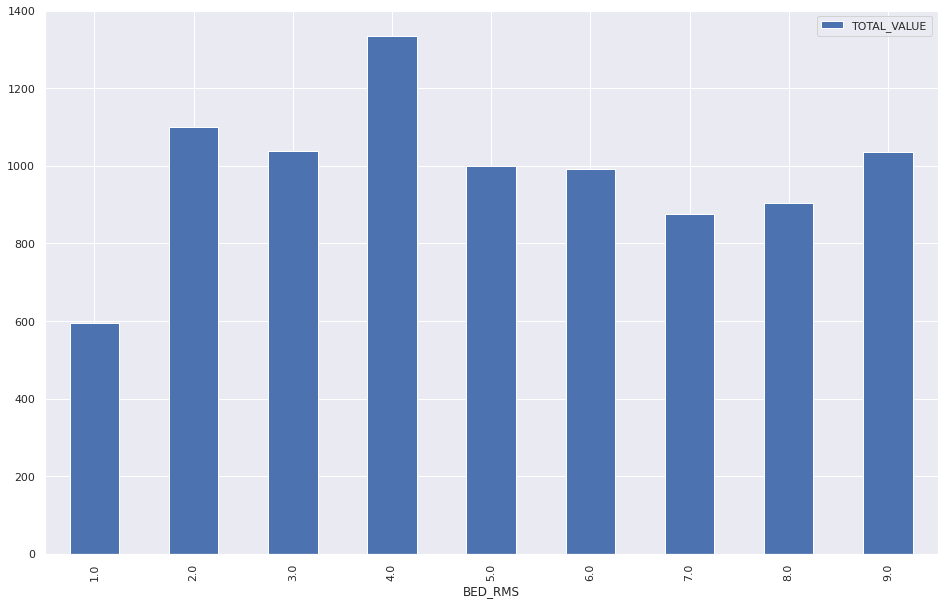

In [383]:
table.plot(kind='bar');

In [384]:
tablebath = pd.pivot_table(data=rentalDimensionalData,index=['FULL_BTH'])
tablebath

,BED_RMS,BLDG_SEQ,BLDG_VALUE,CD_FLOOR,CM_ID,COM_UNITS,FIRE_PLACE,GIS_ID,GROSS_AREA,HLF_BTH,KITCHEN,LAND_SF,LAND_VALUE,LIVING_AREA,LUC,NUM_BLDGS,NUM_PARKING,PID,RES_FLOOR,RES_UNITS,TOTAL_VALUE,TT_RMS,YR_BUILT,YR_REMODEL
FULL_BTH,,,,,,,,,,,,,,,,,,,,,,,,
1.0,1.943078,1.000351,709.542457,2.340126,8.666718e+08,3.445186,1.020379,9.703485e+08,3400.664793,1.001405,1.000351,4890.236824,541.674033,2889.378074,298.287772,1.008082,1.042164,9.703486e+08,2.420063,2.004216,953.151685,4.071680,1914.222066,2009.962052
2.0,2.956569,1.002172,928.355039,2.611292,7.542945e+08,1.000000,1.162866,9.508009e+08,2077.128122,1.011944,1.173724,4063.242128,373.652696,1709.041260,102.262758,1.003257,1.533116,9.508009e+08,1.571661,1.001086,994.641851,6.472313,1909.201954,2010.233442
3.0,6.175407,1.000000,1021.533300,2.175407,5.232403e+08,1.000000,1.182640,1.132659e+09,4678.157324,1.063291,2.500904,3652.607595,286.013588,3300.231465,116.050633,1.005425,1.978300,1.132659e+09,2.675407,1.003617,1257.658452,13.227848,1904.589512,2010.830018
4.0,5.929412,1.000000,1565.236471,1.964706,5.072783e+08,1.000000,1.529412,1.002285e+09,4731.929412,1.094118,2.305882,3872.223529,460.032894,3532.447059,113.023529,1.000000,2.458824,1.002285e+09,2.670588,1.023529,1985.829412,13.494118,1896.788235,2012.117647
5.0,6.636364,1.000000,1454.545455,2.000000,5.038070e+08,1.000000,1.818182,8.845661e+08,5293.181818,1.090909,2.545455,3606.545455,554.790909,3896.454545,104.272727,1.000000,1.909091,8.845661e+08,3.000000,1.000000,2009.336364,13.545455,1899.090909,2013.636364
6.0,7.250000,1.000000,1135.870000,2.000000,5.038070e+08,1.000000,1.300000,1.047688e+09,5436.450000,1.050000,2.900000,3468.900000,348.700000,3902.250000,104.900000,1.000000,2.250000,1.047688e+09,2.975000,1.000000,1484.570000,15.950000,1905.500000,2014.050000


In [385]:
tablebath.drop(tablebath.columns.difference(['TOTAL_VALUE']), 1, inplace=True)

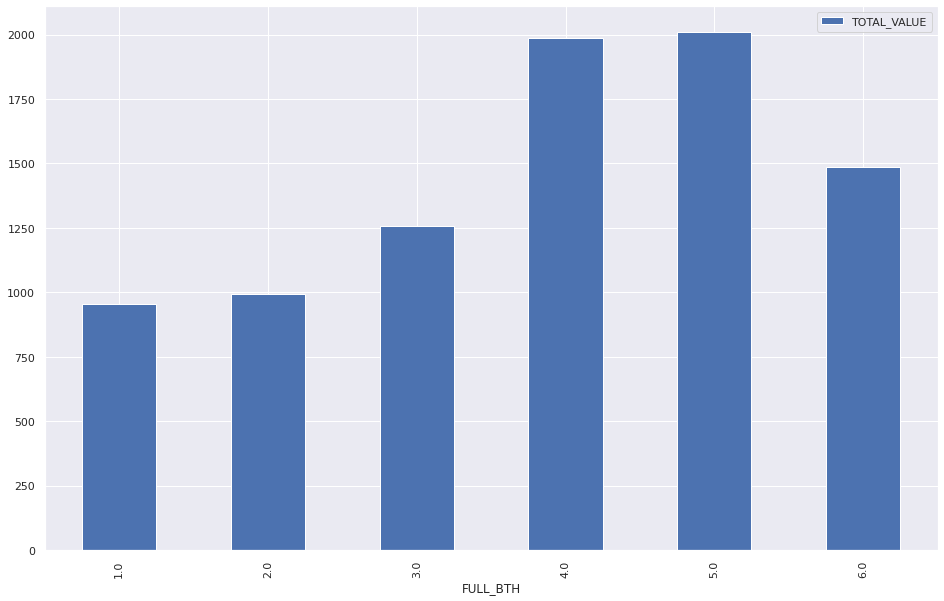

In [386]:
tablebath.plot(kind='bar');

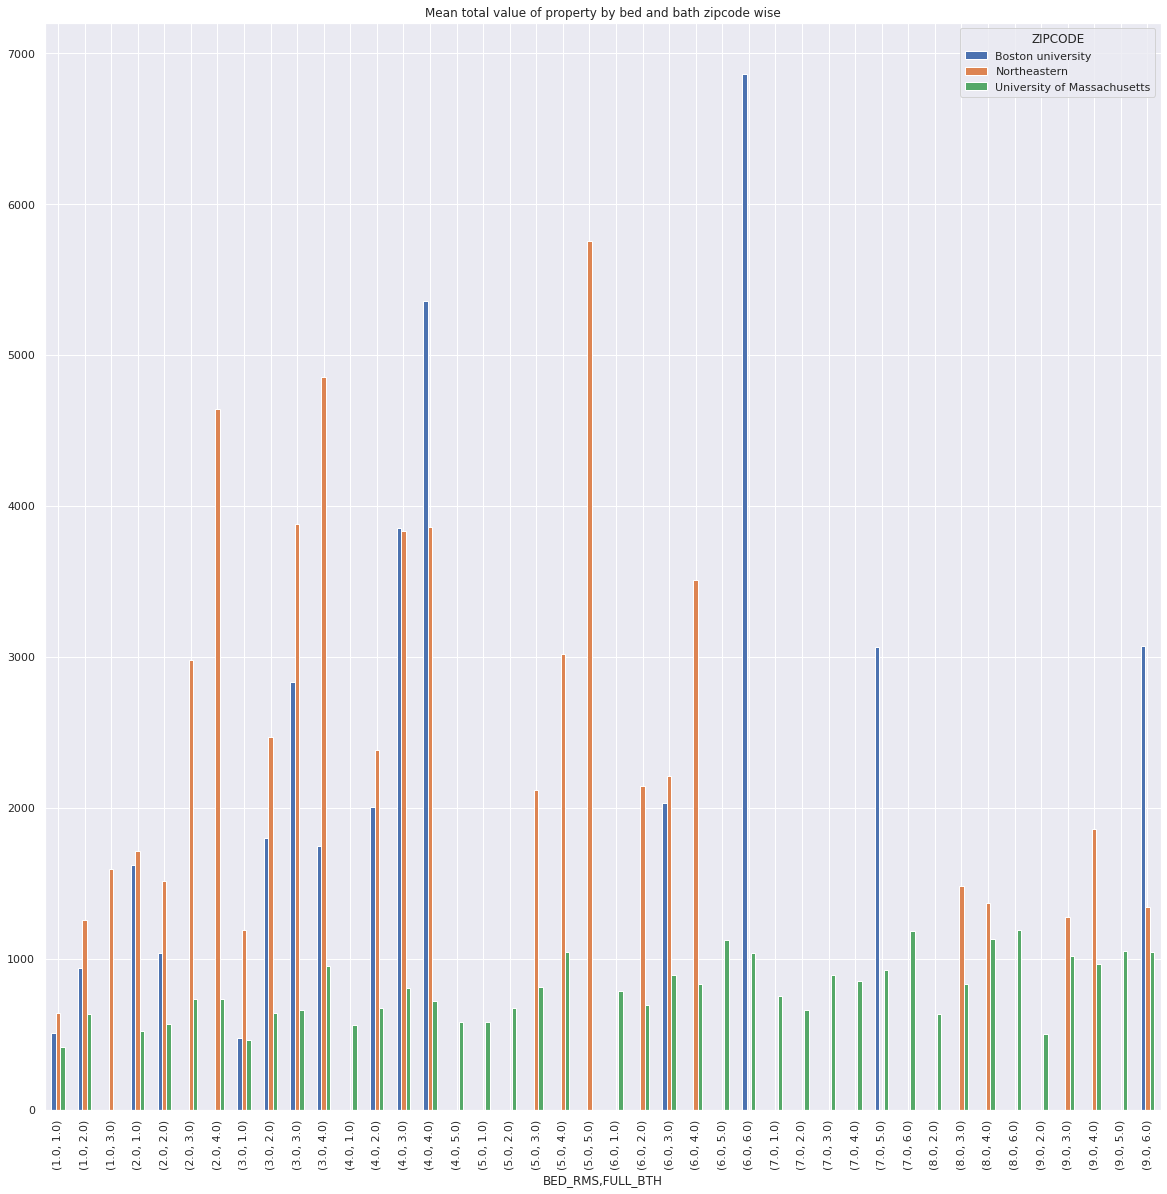

In [387]:
pivotTable = pd.pivot_table(rentalDimensionalData,index=['BED_RMS', 'FULL_BTH'], columns=['ZIPCODE'], values='TOTAL_VALUE', aggfunc=np.mean)
pivotTable.plot(figsize=(20,20), title ='Mean total value of property by bed and bath zipcode wise', kind='bar')

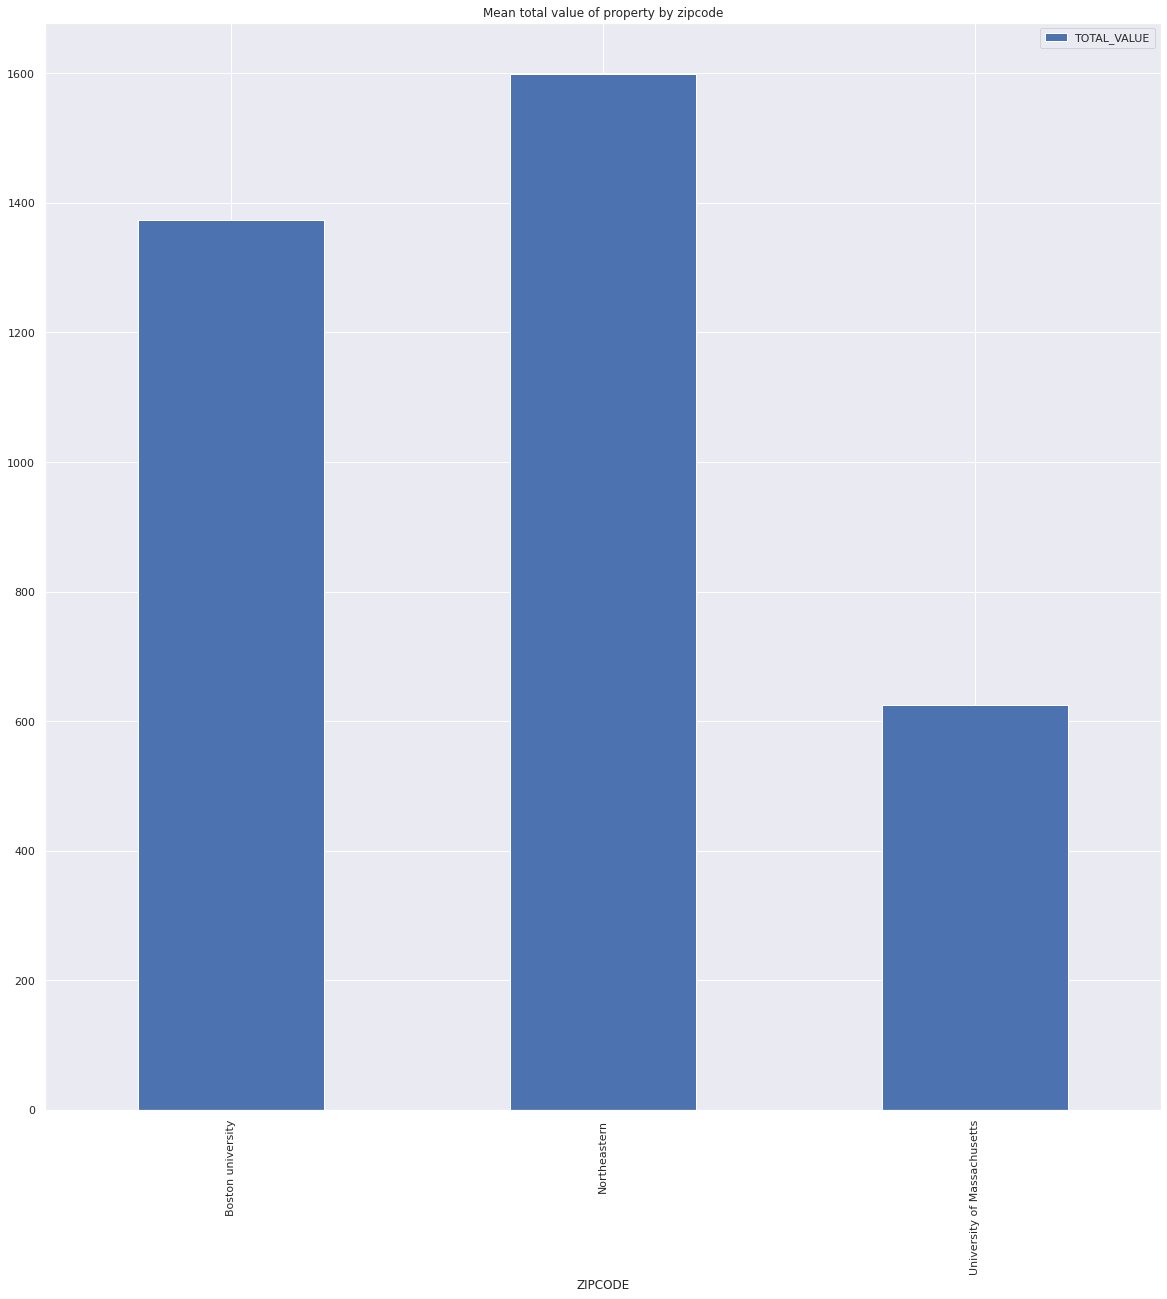

In [389]:
pivotTable = pd.pivot_table(rentalDimensionalData,index=['ZIPCODE'], values='TOTAL_VALUE', aggfunc=np.mean)
pivotTable.plot(figsize=(20,20), title ='Mean total value of property by zipcode', kind='bar')